In [2]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from ipywidgets import interact

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# LR Circuit

A coil (inductance *L*) and a resistor (resistance *R*) are connected to a dc voltage supply (voltage *V<sub>0</sub>*). The voltage is switched on at *t* =0 s. We would like to know how the current in the circuit varies over time.

Qualitatively we know that when the voltage is switched on, the current would increase very quickly, but this leads to a high self-induced emf in the coil. The total voltage in the circuit is therefore lower than the applied voltage. When the current approaches the stationary value, the self-induced voltage decreases and asymptotically tends towards 0.

### Differential Equation

For the voltages in the circuit we have the following relation:

$V_0+V_C(t)=V_R(t)$

$V_0-L\cdot \dot I(t)=R\cdot I(t)$

The current is therefore given by the differential equation

 $\dot I(t)=\dfrac{V_0}{L}-\dfrac{R}{L}\cdot I(t)$


### Exact Solution

We can make an educated guess for the exact solution (ansatz):

$I(t)=I_0\cdot\left(1-e^{-t/\tau}\right)$

Pluggint this into the differential equation, we get:

$\dot I(t)=I_0\cdot e^{-t/\tau}\cdot \frac{1}{\tau}=\dfrac{V_0}{L}-\dfrac{R}{L}\cdot I_0\cdot\left(1-e^{-t/\tau}\right)=\dfrac{V_0}{L}-\dfrac{R\cdot I_0}{L}+\dfrac{R}{L}\cdot e^{-t/\tau}$

For this equation to be fulfilled the factors in front of the expoential function have to be equal and the constant term has to disappear. This leads to

$I_0=\dfrac{V_0}{R}$ and $\tau=\dfrac{L}{R}$

### Numerical Solution

For the numerical solution we investigate a circuit with the following parameters:
- dc voltage *V<sub>0</sub>* = 12 V
- inductance *I* = 10 mH
- resistance *R* = 1.5 kOhm

The predicted time constant is given by

$\tau = \dfrac{L}{R} = \dfrac{\mathrm{10 mH}}{\mathrm{1.5 k}\Omega} = \mathrm{6.7 µs}$

For the numerical solution we choose a time range from 0 to 5 $\tau$.

The code below calculates numerical solution with the Euler method and the Runga-Kutta method. The solution for the latter stays within the standard relative tolerance of 0.001, as can be seen in the lower subplot.

In [3]:
# define function for derivative
def dIdt(t, I, V0, R, L):
    return (V0 - R * I)/L

# define exact solution
def ex_sol(t, A, tau):
    return A * (1 - np.exp(-t / tau))

# define parameters
V0 = 12
R0 = 1500
L = 10e-3

tau = L/R0
tmax = 5*tau

@interact(N=(1, 100), RK=True, Fit=True, Euler=False, Exact=False)
def plot(N=10, RK=True, Fit=True, Euler=False, Exact=False):

    dt = tmax/N
    t = np.linspace(0, tmax, N+1) # array for times
    I_eu = np.zeros(N+1) # prepare empty array for positions

    N_ex = 100 # number of points to plot for exact solution
    t_ex = np.linspace(0, tmax, N_ex) # times for exact solution
    I_ex = ex_sol(t_ex, V0/R0, tau) # positions for exact solution
    I_ex2 = ex_sol(t, V0/R0, tau) # positions at times for numerical solution (for comparison)

    # Euler algorithm
    for i in range(0, N):
        slope = dIdt(0, I_eu[i], V0, R0, L) # get value for slope of current point
        I_eu[i+1] = I_eu[i] + slope * dt # calculate position of next step

    # Runge-Kutta algorithm
    rk = solve_ivp(dIdt, (0, tmax), [0], args=[V0, R0, L], t_eval=t) # call solve_ivp to get solution with RK
    I_rk = rk.y[0] # assign positions (rk.t contains times, rk.y positions)

    # Fit to RK
    param, cov = curve_fit(ex_sol, t, I_rk)
    I0_fit, tau_fit = param
    I_fit = ex_sol(t_ex, I0_fit, tau_fit)

    # prepare stacked plot
    fig, axs = plt.subplots(2, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})
    ax1, ax2 = axs

    tscale = 1e6 # scale factor for time (µs)
    Iscale = 1e3 # scale factor for current (mA)
    
    if RK:
        ax1.scatter(t*tscale, I_rk*Iscale, s=4, c='black', label="Runge-Kutta")

    if Fit:
        ax1.plot(t_ex*tscale, I_fit*Iscale, 'g--', linewidth=1, label='fit to RK')
        ax1.text(3.5*tau*tscale, I0_fit/5*Iscale, f'fit parameters: \n'
                 +r'$I_0$'+f' = {I0_fit*1000:.3f} mA \n'
                 +r'$\tau$'+f' = {tau_fit*1e6:.3f} µs')
    
    if Euler:
        ax1.scatter(t*tscale, I_eu*Iscale, s=4, c='red', label='Euler')
    
    if Exact:
        ax1.plot(t_ex*tscale, I_ex*Iscale, 'b--', linewidth=1, label='exact solution')
        ax1.text(2*tau*tscale, V0/R0/5*Iscale, f'exact values: \n'
                 +r'$I_0$'+f' = {V0/R0*1000:.3f} mA \n'
                 +r'$\tau$'+f' = {tau*1e6:.3f} µs')
    
    ax1.set(xlabel='Time (µs)', ylabel='Current (mA)')
    ax1.grid()
    ax1.legend()

    if Euler:
        diff = I_eu-I_ex2
        ax2.scatter(t*tscale, np.divide(diff, I_ex2, out=np.zeros_like(diff), where=I_ex2!=0), 
                    s=4, c='red', label='Euler – exact')
    if RK:
        diff = I_rk-I_ex2
        ax2.scatter(t*tscale, np.divide(diff, I_ex2, out=np.zeros_like(diff), where=I_ex2!=0), 
                    s=4, c='black', label='RK – exact')
    ax2.grid()
    ax2.legend()
    plt.show()


interactive(children=(IntSlider(value=10, description='N', min=1), Checkbox(value=True, description='RK'), Che…

## Advanced Model

In a slightly advanced model we modify the equation to include a change of the resistance. This is justified if we take the temperature increase of the resistor into account. We assume a linear dependency of the resistance on the current: $R(I) = R_0\cdot (1+m\cdot I)$

The modified differential equation has no obvious exact solution. For small values of the *temperature coefficient m* we expect the solution to have the same behaviour as before, but for larger values it may deviate significantly.

### Numerical solution

In the implementation the code from above has been modified to take into account the temperature coefficient. The value can be varied to see how it affects the solution.

It can indeed be observed that the simple model is no longer a good approximation for larger values of the temperature coefficient. The same type of function is still a good approximation (see fit function), but both the stationary current and the time constant are smaller than in the simplified model.

The temperature coefficient in the model can also set to negative values. This corresponds to a resistance which decreases when the current increases (NTC resistor). In this case the deviation from the simplified model is in the opposite direction, i.e. the stationary current and the time constant are smaller.

The relative deviation is now calculated with respect to the simplified model since we do not have an exact solution to compare to. For large values of the temperature coefficient the deviation is greater than the tolerance of the algorithm, which tells us that the exact solution has a different behaviour than the fit function.

Something interesting happens for large negative values of the temperature coefficient: The graph starts to oscillate around the expected trend. This happens when the resistance drops to 0. This interesting phenomenon could be investigated in more detail.

In [4]:
# define function for derivative (with temperatur coefficient)
def dIdt(t, I, V0, R0, L, m):
    return (V0 - max((R0 + m * I), 0) * I)/L # resistance cannot be negative -> max(R, 0)

# define simplified solution (m=0)
def simp_sol(t, A, tau):
    return A * (1 - np.exp(-t / tau))

# define parameters
V0 = 12
R0 = 1500
L = 10e-3

tau = L/R0
tmax = 5*tau

@interact(N=(1, 100), m=(-200000, 1000000, 5000), RK=True, Fit=True, Simplified=True)
def plot(N=10, m=-50000, RK=True, Fit=True, Simplified=True):

    t = np.linspace(0, tmax, N+1) # array for times

    N_simp = 100 # number of points to plot for simplified solution (m=0)
    t_simp = np.linspace(0, tmax, N_simp) # times for simplified solution
    I_simp = simp_sol(t_simp, V0/R0, tau) # positions for exact solution

    # Runge-Kutta algorithm
    rk = solve_ivp(dIdt, (0, tmax), [0], args=[V0, R0, L, m], t_eval=t) # call solve_ivp to get solution with RK
    I_rk = rk.y[0] # assign positions (rk.t contains times, rk.y positions)

    # Fit to RK
    param, cov = curve_fit(simp_sol, t, I_rk)
    I0_fit, tau_fit = param
    I_fit = simp_sol(t_simp, I0_fit, tau_fit)
    I_fit2 = simp_sol(t, I0_fit, tau_fit)

    # prepare stacked plot
    fig, axs = plt.subplots(2, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})
    ax1, ax2 = axs

    tscale = 1e6 # scale factor for time (µs)
    Iscale = 1e3 # scale factor for current (mA)
    
    if RK:
        ax1.scatter(t*tscale, I_rk*Iscale, s=4, c='black', label="Runge-Kutta")

    if Fit:
        ax1.plot(t_simp*tscale, I_fit*Iscale, 'g--', linewidth=1, label='fit to RK')
        ax1.text(3.5*tau*tscale, I_fit[-1]/5*Iscale, f'fit parameters: \n'
                 +r'$I_0$'+f' = {I0_fit*1000:.3f} mA \n'
                 +r'$\tau$'+f' = {tau_fit*1e6:.3f} µs')
    
    if Simplified:
        ax1.plot(t_simp*tscale, I_simp*Iscale, 'b--', linewidth=1, label='simplified solution (m=0)')
        ax1.text(2*tau*tscale, I_fit[-1]/5*Iscale, f'simplified model: \n'
                 +r'$I_0$'+f' = {V0/R0*1000:.3f} mA \n'
                 +r'$\tau$'+f' = {tau*1e6:.3f} µs')
    
    ax1.set(xlabel='Time (µs)', ylabel='Current (mA)')
    ax1.grid()
    ax1.legend()

    if RK:
        diff = I_rk-I_fit2
        ax2.scatter(t*tscale, np.divide(diff, I_fit2, out=np.zeros_like(diff), where=I_fit2!=0), 
                    s=4, c='black', label='RK – fit')
    ax2.grid()
    ax2.legend()

    # plt.show()


def dIdt_nl(t, I, V0, R0, L, m):
    return (V0 - (R0 + m * I) * I)/L

m = 1e4


interactive(children=(IntSlider(value=10, description='N', min=1), IntSlider(value=-50000, description='m', ma…

In [5]:
@interact(m=(-100000, 50000, 500))
def plot(m=10000):
    I = np.linspace(-200e-3, 200e-3, 100)
    Idot = V0/L - (R0 + m*I)*I/L
    Ifix1 = (-R0+np.sqrt(R0*R0+4*m*V0))/(2*m)
    Ifix2 = (-R0-np.sqrt(R0*R0+4*m*V0))/(2*m)

    plt.plot(I, Idot)
    plt.scatter([Ifix1, Ifix2], [0, 0])
    plt.text(Ifix1, 500, f'{Ifix1*1000:.3f}')
    plt.text(Ifix2, 500, f'{Ifix2*1000:.3f}')
    plt.grid()
    plt.show()


interactive(children=(IntSlider(value=10000, description='m', max=50000, min=-100000, step=500), Output()), _d…

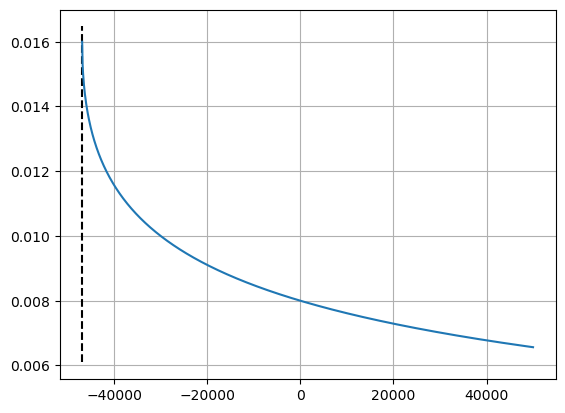

In [47]:
m0 = -R0*R0/(4*V0)
m = np.linspace(m0, 5e4, 1000)

Ifix = (-R0+np.sqrt(R0*R0+4*m*V0))/(2*m)

fig, ax = plt.subplots()
ax.plot(m, Ifix)
ylim = ax.get_ylim()
ax.vlines(m0, ylim[0], ylim[1], colors='black', linestyles='dashed')
plt.grid()
plt.show()
